# NIHCXR Clinical Drift

## Load Libraries

In [1]:
from cyclops.datasets.slicer import SliceSpec
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from torchxrayvision.models import DenseNet
from cyclops.monitor.utils import load_nihcxr, get_device
from cyclops.datasets.utils import apply_transforms

from monai.transforms import Compose, AddChanneld, Resized, Lambdad, ToDeviced
from functools import partial

## Query Data

In [2]:
nih_ds = load_nihcxr("/home/akore/NIHCXR/")

## Split Source/Target Datasets

In [3]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}])

shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/48780 [00:00<?, ? examples/s]

In [4]:
device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

## Initalize Detector (Reductor+Tester) and Run Sensitivity Test

In [7]:
nih_ds = load_nihcxr("/mnt/data/NIHCXR/")

source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}])
shifter = ClinicalShiftApplicator("custom", 
                                  source=source_slice, 
                                  target=target_slice)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

model = DenseNet(weights="densenet121-res224-all")
reductors = {"BBSE": Reductor(dr_method="bbse-soft", model=model, device=device),
             "BBSE + TXRV-AE": Reductor(dr_method="bbse-soft+txrv-ae", model=model, device=device),
             "TXRV-AE": Reductor(dr_method="txrv-ae", device=device),
             }

for name, reductor in reductors.items():
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=1000,
        target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
        num_runs=3
    )
    detector.detect_shift(source_ds, target_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft+txrv-ae", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_ae = detector.detect_shift(source_ds, target_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="txrv-ae", device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

ae = detector.detect_shift(source_ds, target_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

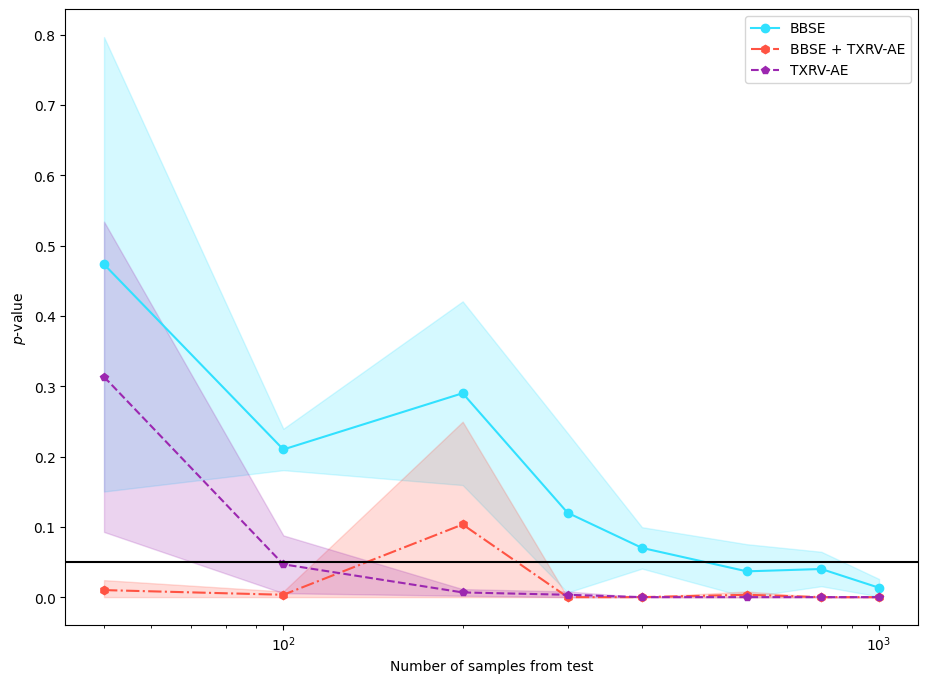

In [10]:
from cyclops.monitor.plotter import plot_drift_samples_pval

results = {"BBSE": 
           {
               "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse["p_val"].mean(axis=0),
                "std_p_vals": bbse["p_val"].std(axis=0)
           },
           "BBSE + TXRV-AE":
           {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_ae["p_val"].mean(axis=0),
                "std_p_vals": bbse_ae["p_val"].std(axis=0)
            },
            "TXRV-AE":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": ae["p_val"].mean(axis=0),
                "std_p_vals": ae["p_val"].std(axis=0)
            }
          }

plot_drift_samples_pval(results, p_val_threshold=0.05)

In [ ]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_F = detector.detect_shift(source_ds, target_ds)

In [ ]:
source_slice = None
target_slices = {"SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
                "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
                "AGE: 18-35": SliceSpec(spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]),
                "AGE: 35-65": SliceSpec(spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]),
                }

for name, target_slice in target_slices.items():
    source_slice = None
    target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}])
    shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)
    source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

    detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
    )
    detector.detect_shift(source_ds, target_ds)

In [11]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_M = detector.detect_shift(source_ds, target_ds)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/63340 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_age_18_35 = detector.detect_shift(source_ds, target_ds)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/24483 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_age_35_65 = detector.detect_shift(source_ds, target_ds)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/70151 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Age": {"min_value": 65, "max_value": 100}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)

bbse_age_65_100 = detector.detect_shift(source_ds, target_ds)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/16054 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

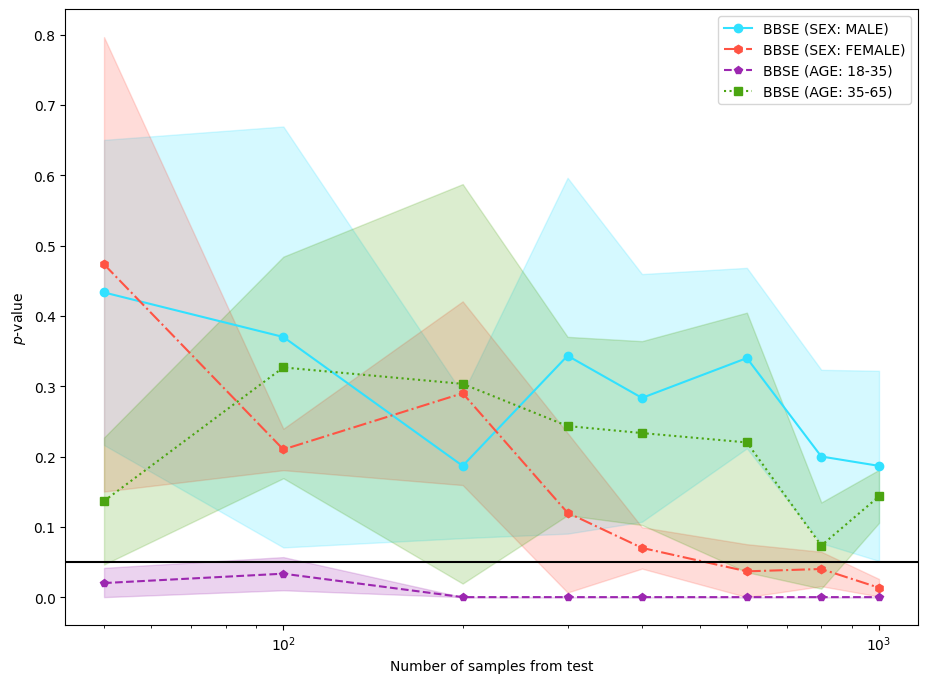

In [16]:
from cyclops.monitor.plotter import plot_drift_samples_pval

results = {
            "BBSE (SEX: MALE)":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_M["p_val"].mean(axis=0),
                "std_p_vals": bbse_M["p_val"].std(axis=0)
            },
            "BBSE (SEX: FEMALE)":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse["p_val"].mean(axis=0),
                "std_p_vals": bbse["p_val"].std(axis=0)
            },
            "BBSE (AGE: 18-35)": 
           {
               "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_age_18_35["p_val"].mean(axis=0),
                "std_p_vals": bbse_age_18_35["p_val"].std(axis=0)
           },
              "BBSE (AGE: 35-65)":
              {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_age_35_65["p_val"].mean(axis=0),
                "std_p_vals": bbse_age_35_65["p_val"].std(axis=0)
              },
              # "BBSE (AGE: 65-100)":
              #   {
              #   "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
              #   "mean_p_vals": bbse_age_65_100["p_val"].mean(axis=0),
              #   "std_p_vals": bbse_age_65_100["p_val"].std(axis=0)
              #   }
          }

plot_drift_samples_pval(results, p_val_threshold=0.05)

In [ ]:
models = {"MODEL: NIH": "densenet121-res224-nih", 
          "MODEL: CHEXPERT": "densenet121-res224-chex",
          "MODEL: PADCHEST": "densenet121-res224-pc"}

for model_name, model in models.items():
        detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=DenseNet(model), device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=1000,
        target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
        num_runs=3
        )
        detector.detect_shift(source_ds, target_ds)


model = DenseNet(weights="densenet121-res224-nih")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_nih = detector.detect_shift(source_ds, target_ds)

model = DenseNet(weights="densenet121-res224-chex")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_chex = detector.detect_shift(source_ds, target_ds)

model = DenseNet(weights="densenet121-res224-pc")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_pc = detector.detect_shift(source_ds, target_ds)

In [17]:
source_slice = None
target_slice = SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}])
shifter = ClinicalShiftApplicator("custom", source=source_slice, target=target_slice)

source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

device = get_device()
transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

# transforms = txrv_transforms(keys=("features",), device=device)
source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

model = DenseNet(weights="densenet121-res224-nih")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_nih = detector.detect_shift(source_ds, target_ds)

model = DenseNet(weights="densenet121-res224-chex")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_chex = detector.detect_shift(source_ds, target_ds)

model = DenseNet(weights="densenet121-res224-pc")
detector = Detector(
    "sensitivity_test",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=[50, 100, 200, 300, 400, 600, 800, 1000],
    num_runs=3
)
bbse_pc = detector.detect_shift(source_ds, target_ds)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):   0%|          | 0/48780 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /home/akore/.torchxrayvision/models_data/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/pc-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /home/akore/.torchxrayvision/models_data/pc-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

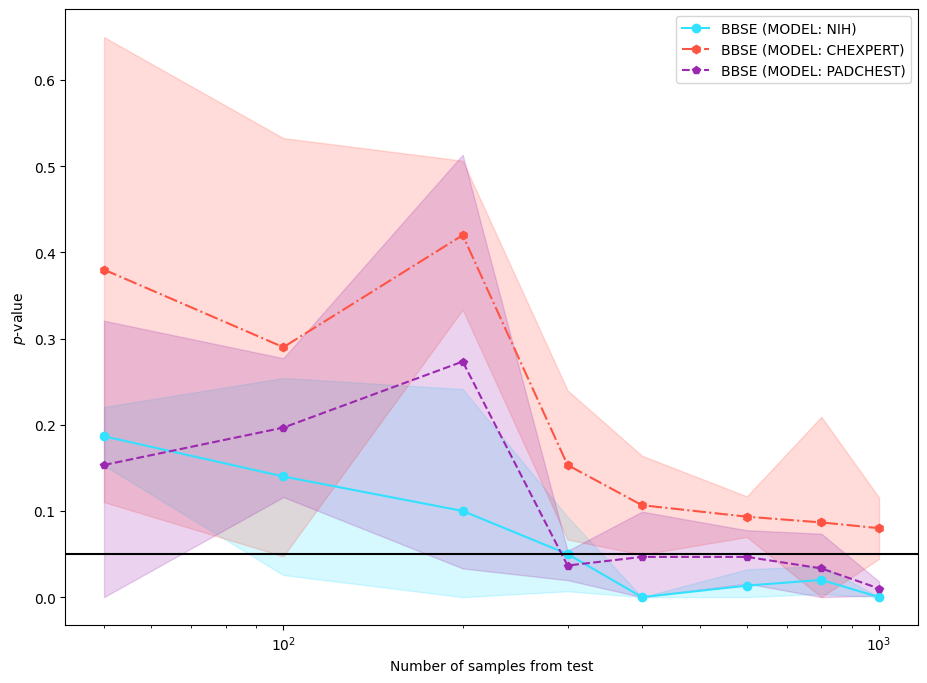

In [18]:
from cyclops.monitor.plotter import plot_drift_samples_pval

results = {
            "BBSE (MODEL: NIH)":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_nih["p_val"].mean(axis=0),
                "std_p_vals": bbse_nih["p_val"].std(axis=0)
            },
            "BBSE (MODEL: CHEXPERT)":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_chex["p_val"].mean(axis=0),
                "std_p_vals": bbse_chex["p_val"].std(axis=0)
            },
            "BBSE (MODEL: PADCHEST)":
            {
                "samples": [50, 100, 200, 300, 400, 600, 800, 1000],
                "mean_p_vals": bbse_pc["p_val"].mean(axis=0),
                "std_p_vals": bbse_pc["p_val"].std(axis=0)
            }
          }

plot_drift_samples_pval(results, p_val_threshold=0.05)

In [10]:
from cyclops.evaluate.evaluator import evaluate
from cyclops.evaluate.metrics import MultilabelAUROC
from cyclops.models.wrappers import PTModel
from torch.nn import BCEWithLogitsLoss
pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", 
           "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]
model = DenseNet(weights="densenet121-res224-all")
wrapped_model = PTModel(model, BCEWithLogitsLoss, device=device)
results = evaluate(source_ds, 
                   MultilabelAUROC(14), 
                   models=wrapped_model,
                   feature_columns="features", 
                   target_columns = pathologies,
                   remove_columns="features",
                   )

## Initalize Detector (Reductor+Tester) and Run Rolling Window Experiment

In [20]:
model = DenseNet(weights="densenet121-res224-all")

detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device="cuda"),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=1000,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W"
)

bbse_rw = detector.detect_shift(source_ds, target_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

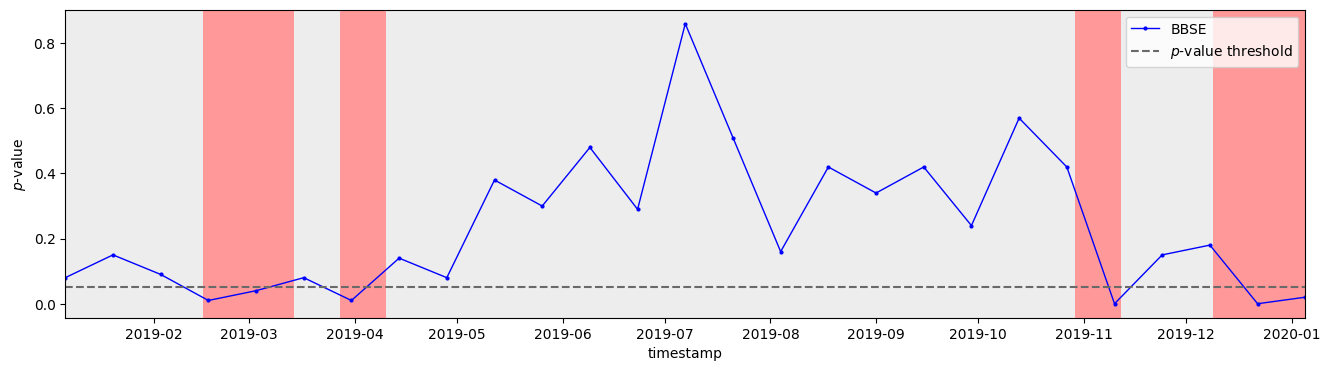

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
results = bbse_rw

sig_drift = results["shift_detected"]

fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))
cmap = ListedColormap(["lightgrey", "red"])
ax1.plot(
    results["timestamps"],
    results["p_val"][0],
    ".-",
    color="blue",
    linewidth=1.0,
    markersize=4,
    label="BBSE"
)
ax1.set_xlim(results["timestamps"][0], results["timestamps"][-1])
ax1.axhline(y=0.05, color="dimgrey", linestyle="--", label="$p$-value threshold")
ax1.set_ylabel("$p$-value")
ax1.set_xlabel("timestamp")
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(), sig_drift, cmap=cmap, alpha=0.4)
ax1.legend()